In [90]:
%reload_ext autoreload
%autoreload 2

In [58]:
import os, sys
import re
import json
import glob
import datetime
import nltk
import spacy
import pyLDAvis
import pyLDAvis.gensim
import gensim
import gensim.corpora as corpora
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel
from collections import Counter

import pandas as pd
from pandas import DataFrame
from matplotlib import pyplot as plt
import seaborn as sns

from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize
from wordcloud import WordCloud
from textblob import TextBlob
from pprint import pprint
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)

In [3]:
# Add parent directory to path to import modules from src
rpath = os.path.abspath('..')
if rpath not in sys.path:
    sys.path.insert(0, rpath)

from src.loader import SlackDataLoader
import src.utils as utils

### Columns we can get from a slack message<br>

message_type, message_content, sender_id, time_sent, message_distribution, time_thread_start, reply_count, reply_user_count, time_thread_end, reply_users

From a single slack message, we can get <br>

1. The message<br>
2. Type (message, file, link, etc)<br>
3. The sender_id (assigned by slack)<br>
4. The time the message was sent<br>
5. The team (i don't know what that is now)<br>
6. The type of the message (broadcast message, inhouse, just messgae)<br>
7. The thread the message generated (from here we can go):<br>
    7.1 Text/content of the message<br>
    7.2 The thread time of the message<br>
    7.3 The thread count (reply count)<br>
    7.4 The number of user that reply the message (count of users that participated in the thread)<br>
    7.5 The time the last thread message was sent <br>
    7.6 The users that participated in the thread (their ids are stored as well)<br>

In [24]:
loader = SlackDataLoader("../src/anonymized/")
channel = loader.get_channels()
all_data = []
all_messages = []
for i in channel:
    data = loader.slack_parser(f"../src/anonymized/{i['name']}/")
    all_data.append(data)
print(all_data)
for j in channel:
    messages = loader.slack_parser(f"../src/anonymized/{j['name']}/")
    all_messages.append(messages)

# print(all_messages)
df = pd.concat(all_data, ignore_index=True)
# print (df.columns)
# df.head(20)

[     msg_type                                        msg_content  \
0     message  <#C03T0APHX63|all-community-building>\n*<!chan...   
1     message                                     lovely drawing   
2     message                Good morning everyone:raised_hands:   
3     message                                Hello:raised_hands:   
4     message                                                 HI   
...       ...                                                ...   
7608  message  <@U03UG4Q7V42> You are my suspect for all yest...   
7609  message       <@U03UJGP0C68> <@U03UUR571A5> <@U03UG4Q7V42>   
7610  message  That is not even there to have 20 PL titles wi...   
7611  message              Bro we humbled liverpool :sunglasses:   
7612  message                      <@U03UG32J3PC> :dagger_knife:   

           sender_name      msg_sent_time msg_dist_type  time_thread_start  \
0        Travis Butler  1662309581.795939       channel                  0   
1     Katherine Foster  16

In [8]:
# Who are the top 10  users by replay count?
user_reply_counts = df.groupby('sender_name')['reply_count'].sum().sort_values(ascending=False)
top_10_users = user_reply_counts.head(10)
# print(top_10_users)
pd.DataFrame({'sender_name': top_10_users.index,
'reply_count': top_10_users.values})

,sender_name,reply_count
0,Cristian Wilson,620
1,Vanessa Norman,462
2,Brian Odom,367
3,Brenda Hernandez,307
4,Michelle Lewis,306
5,April Lucas,302
6,Travis Butler,299
7,Amy Leon,282
8,Joshua Rhodes,247
9,Brady Rhodes,242


In [9]:
# Who are the bottom 10  users by replay count?
user_reply_counts = df.groupby('sender_name')['reply_count'].sum().sort_values(ascending=False)
bottom_10_users = user_reply_counts.tail(10)
pd.DataFrame({'sender_name': bottom_10_users.index,
'reply_count': bottom_10_users.values})

,sender_name,reply_count
0,Randy Miller,4
1,Leah Newton,2
2,Blake Scott,0
3,Patrick Hernandez,0
4,Patricia Thomas,0
5,Slackbot,0
6,Christopher Case,0
7,Holly Whitaker,0
8,Erica Munoz,0
9,David Scott,0


In [44]:
# Who are the top 10  users by mention count?
mentioned_users = utils.get_tagged_users(df)
loader.get_users()

users_map = loader.get_user_map()[0]
user_names_list = pd.DataFrame({
    'user_id' : list(users_map.keys()),
    'user_name': list(users_map.values())
})

user_ids = []
for id in mentioned_users:
	if id:
		user_ids.append(id[0][1:])

all_mentioned_ids = pd.DataFrame({'user_id': user_ids})


mentioned_users = user_names_list.merge(all_mentioned_ids, on='user_id', how='inner')
mentioned_users_count = mentioned_users.groupby('user_id').value_counts()
top_10_user = mentioned_users_count.sort_values(ascending=False).head(10)
pd.DataFrame(top_10_user)

,,count
user_id,user_name,
U03V1AM5TFA,Vanessa,174
U03TEPYRM2P,Garrett,165
U03UVHCV6KB,Travis,149
U03UUR571A5,Amy,143
U03UG32J3PC,April,139
U03UG4Q7V42,Phillip,111
U03UD68RQH3,Brady,110
U03UJGP0C68,Judith,109
U03UJKJGRAQ,Brian,102


In [45]:
# Who are the bottom 10  users by mention count?
bottom_10_user = mentioned_users_count.sort_values(ascending=False).tail(10)
pd.DataFrame(bottom_10_user)

,,count
user_id,user_name,
U03U1J51VFZ,Cheryl,11
U03UG569P7U,Melissa,7
U03UJGFG2HJ,Vernon,6
U03UKGSDGSG,Leah,5
U03U1FQKEMV,Steven,3
U03UD63A8PP,Randy,3
U03TNP8Q8CT,Bethany,3
U03UG1RTXAP,Carol,3
U03UYNR4TS4,Patrick,2


In [11]:
# Who are the top users by Message count?
user_message_counts = df['sender_name'].value_counts()
top_10_users = user_message_counts.head(10)
pd.DataFrame({'sender_name': top_10_users.index, 'message_count': top_10_users.values}) 

,sender_name,message_count
0,Vanessa Norman,1288
1,Amy Leon,1150
2,Travis Butler,1075
3,April Lucas,991
4,Brenda Hernandez,843
5,Cristian Wilson,831
6,Phillip Atkins,754
7,Brady Rhodes,641
8,Judith Bolton,574
9,Joshua Rhodes,519


In [12]:
# Who are the bottom users by Message count?
bottom_10_users = user_message_counts.tail(10)
pd.DataFrame({'sender_name': bottom_10_users.index, 'message_count': bottom_10_users.values})

,sender_name,message_count
0,Leah Newton,10
1,Patricia Thomas,8
2,Randy Miller,7
3,Patrick Hernandez,5
4,Slackbot,3
5,Erica Munoz,1
6,Christopher Case,1
7,Holly Whitaker,1
8,David Scott,1
9,Blake Scott,1


In [68]:
# Who are the top users by Reaction count?


In [ ]:
# Who are the bottom users by Reaction count?

In [69]:
# What are the top 10 messages by Replies?
# processes = utils.process_msgs(all)
# print(processes)

In [70]:
# message_list = utils.get_msgs_df_info(df)
# print(message_list)

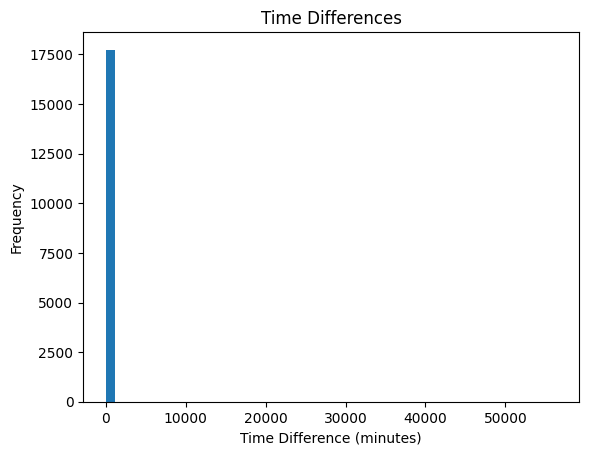

In [63]:
# distribution of time differences
df['msg_sent_time'] = pd.to_datetime(df['msg_sent_time'])  # convert to datetime
# df['msg_sent_time']
df = df.sort_values('msg_sent_time')
df['time_diff'] = df['msg_sent_time'].diff()
# print(df['time_diff'].describe())

df['time_diff_minutes'] = df['time_diff'].dt.total_seconds() / 60 # Convert the time differences to minutes

# Plot a histogram of the time differences
plt.hist(df['time_diff_minutes'].dropna(), bins=50)
plt.title('Time Differences')
plt.xlabel('Time Difference (minutes)')
plt.ylabel('Frequency')
plt.show()


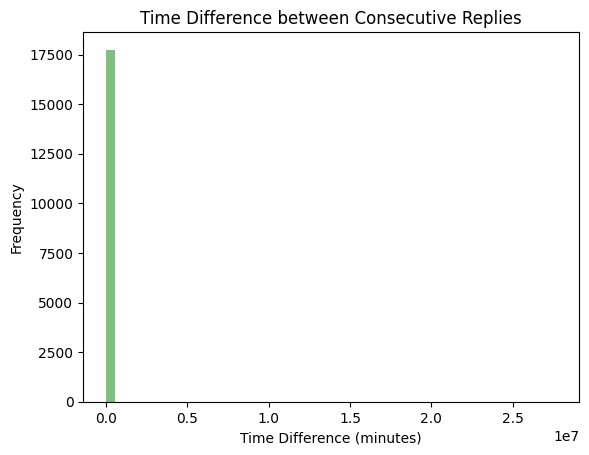

In [114]:
# distribution of time differences
df['time_thread_start'] = pd.to_datetime(df['time_thread_start'])

df = df.sort_values('time_thread_start')

df['time_diff'] = df['time_thread_start'].diff()

df['time_diff'] = df['time_diff'].dt.total_seconds() / 60

# Plot a histogram of the time differences
plt.hist(df['time_diff'].dropna(), bins=50, alpha=0.5, color='green')
plt.title('Time Difference between Consecutive Replies')
plt.xlabel('Time Difference (minutes)')
plt.ylabel('Frequency')
plt.show()

In [5]:

stop_words = stopwords.words('english')
print(stop_words)

['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've", "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', 'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their', 'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', 'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', 'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', 'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after', 'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further', 'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more', 'most', 'other', 'some', 'such', 'no', 'nor', 'not', 'only', 'own', 'same', 'so', 'than', '

In [77]:
data = df['msg_content'].values.tolist()
data = [re.sub(r'\S*@\S*\s?', '', sent) for sent in data]
data = [re.sub(r'\s+', ' ', sent) for sent in data]
data = [re.sub(r"\'", "", sent) for sent in data]
data = [re.sub(r"@U\w+", "", sent) for sent in data]

def lemmatization(texts, allowed_postags=["NOUN", "ADJ", "VERB", "ADV"]):
    nlp = spacy.load("en_core_web_sm", disable=["parser", "ner"])
    texts_out = []
    for text in texts:
        doc = nlp(text)
        new_text = []
        for token in doc:
            if token.pos_ in allowed_postags:
                new_text.append(token.lemma_)
        final = " ".join(new_text)
        texts_out.append(final)
    return (texts_out)

lemmatized_texts = lemmatization(data)
print(lemmatized_texts[1][0:50])

lovely drawing


In [78]:
def gen_words(texts):
    final = []
    for text in texts:
        new = gensim.utils.simple_preprocess(text, deacc=True)
        final.append(new)
    return (final)

data_words = gen_words(lemmatized_texts)

print (data_words[0][0:20])

['aphx', 'all', 'community', 'building', 'maybe', 'time', 'watch', 'maybe', 'matter', 'choose', 'video', 'just', 'know', 'sure', 'only', 'worth', 'time', 'also', 'most', 'underrated']


In [79]:
#BIGRAMS AND TRIGRAMS
bigram_phrases = gensim.models.Phrases(data_words, min_count=5, threshold=100)
trigram_phrases = gensim.models.Phrases(bigram_phrases[data_words], threshold=100)

bigram = gensim.models.phrases.Phraser(bigram_phrases)
trigram = gensim.models.phrases.Phraser(trigram_phrases)

def make_bigrams(texts):
    return([bigram[doc] for doc in texts])

def make_trigrams(texts):
    return ([trigram[bigram[doc]] for doc in texts])

data_bigrams = make_bigrams(data_words)
data_bigrams_trigrams = make_trigrams(data_bigrams)

print (data_bigrams_trigrams[0][0:20])

['aphx', 'all', 'community_building', 'maybe', 'time', 'watch', 'maybe', 'matter', 'choose', 'video', 'just', 'know', 'sure', 'only', 'worth', 'time', 'also', 'most', 'underrated', 'source']


In [80]:
#TF-IDF REMOVAL
from gensim.models import TfidfModel

id2word = corpora.Dictionary(data_bigrams_trigrams)

texts = data_bigrams_trigrams

corpus = [id2word.doc2bow(text) for text in texts]
# print (corpus[0][0:20])

tfidf = TfidfModel(corpus, id2word=id2word)

low_value = 0.03
words  = []
words_missing_in_tfidf = []
for i in range(0, len(corpus)):
    bow = corpus[i]
    low_value_words = [] #reinitialize to be safe. You can skip this.
    tfidf_ids = [id for id, value in tfidf[bow]]
    bow_ids = [id for id, value in bow]
    low_value_words = [id for id, value in tfidf[bow] if value < low_value]
    drops = low_value_words+words_missing_in_tfidf
    for item in drops:
        words.append(id2word[item])
    words_missing_in_tfidf = [id for id in bow_ids if id not in tfidf_ids] # The words with tf-idf socre 0 will be missing

    new_bow = [b for b in bow if b[0] not in low_value_words and b[0] not in words_missing_in_tfidf]
    corpus[i] = new_bow

In [81]:
lda_model = gensim.models.ldamodel.LdaModel(corpus=corpus[:-1],
                                           id2word=id2word,
                                           num_topics=10,
                                           random_state=100,
                                           update_every=1,
                                           chunksize=100,
                                           passes=10,
                                           alpha="auto")

In [82]:
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim.prepare(lda_model, corpus, id2word, mds="mmds", R=30)
vis

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
3      0.387507  0.222743       1        1  15.689977
8      0.126438  0.394806       2        1  15.507642
9     -0.338735 -0.291936       3        1  14.036550
7     -0.228467  0.397244       4        1  11.611707
4      0.176162 -0.423084       5        1  10.534096
2     -0.176336  0.153506       6        1   9.265275
5     -0.062546 -0.308064       7        1   8.283909
1     -0.406090  0.006742       8        1   6.825494
6      0.144098 -0.030762       9        1   4.234749
0      0.377968 -0.121195      10        1   4.010601, topic_info=                  Term         Freq        Total Category  logprob  loglift
141                use  1392.000000  1392.000000  Default  30.0000  30.0000
587                try  1225.000000  1225.000000  Default  29.0000  29.0000
150               work  1330.000000  1330.000000  Default  28.0000  28.0000
46                here   768.000000   768.000000  Default  27.0000  27.0000
126                 so   796.000000   796.000000  Default  26.0000  26.0000
...                ...          ...          ...      ...      ...      ...
262                 th    22.931708    23.753096  Topic10  -4.9994   3.1810
887                map    22.833839    23.667715  Topic10  -5.0037   3.1804
1223  as_soon_possible    21.982893    22.803359  Topic10  -5.0417   3.1796
60    http_meet_google    18.779402    19.599783  Topic10  -5.1992   3.1735
6921              port    40.233980    47.315149  Topic10  -4.4373   3.0541

[335 rows x 6 columns], token_table=      Topic      Freq       Term
term                            
779       6  0.995587       able
90        6  0.990124      above
308       7  0.971570    academy
1196      4  0.996570     access
1862      8  0.993108    account
...     ...       ...        ...
41        5  0.996133       well
150       3  0.999217       work
465       3  0.995253      write
386       4  0.995111  yesterday
331       4  0.997881        yet

[322 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[4, 9, 10, 8, 5, 3, 6, 2, 7, 1])

In [83]:
for i, channel_data in enumerate(all_data):
    combined_text = channel_data['msg_content'].tolist()  # Extract text data from 'msg_content' column
    # Preprocess text data
    lemmatized_texts = lemmatization(combined_text)
    data_words = gen_words(lemmatized_texts)
    
    # Apply topic modeling on the data_words
    id2word = corpora.Dictionary(data_words)
    corpus = [id2word.doc2bow(text) for text in data_words]
    
    top_topics = lda_model.show_topics(num_topics=10, num_words=5)
    print(f"Top 10 topics for Channel {i+1}:")
    for topic_number, words in top_topics:
        print(f"Topic {topic_number}: {words}")


Top 10 topics for Channel 1:
Topic 0: 0.095*"group" + 0.071*"link" + 0.062*"give" + 0.038*"tutorial" + 0.036*"request"
Topic 1: 0.114*"get" + 0.051*"sure" + 0.044*"see" + 0.042*"then" + 0.038*"instal"
Topic 2: 0.177*"use" + 0.039*"connect" + 0.037*"feature" + 0.026*"end" + 0.026*"submit"
Topic 3: 0.061*"now" + 0.054*"line" + 0.046*"file" + 0.037*"same" + 0.033*"start"
Topic 4: 0.089*"so" + 0.087*"thank" + 0.084*"think" + 0.061*"error" + 0.038*"run"
Topic 5: 0.174*"try" + 0.109*"here" + 0.073*"time" + 0.058*"make" + 0.039*"open"
Topic 6: 0.114*"task" + 0.092*"find" + 0.043*"folder" + 0.042*"very" + 0.038*"name"
Topic 7: 0.068*"datum" + 0.050*"instance" + 0.042*"good" + 0.040*"week" + 0.039*"go"
Topic 8: 0.039*"guy" + 0.035*"create" + 0.032*"install" + 0.032*"need" + 0.031*"read"
Topic 9: 0.112*"work" + 0.047*"just" + 0.037*"let" + 0.031*"today" + 0.030*"right"
Top 10 topics for Channel 2:
Topic 0: 0.095*"group" + 0.071*"link" + 0.062*"give" + 0.038*"tutorial" + 0.036*"request"
Topic 1: 

In [93]:
df['msg_sent_time'] = pd.to_datetime(df['msg_sent_time'], unit='s')

# Extract day since the start of the training
start_date = df['msg_sent_time'].min().date()
df['days_since_start'] = (df['msg_sent_time'].dt.date - start_date).apply(lambda x: x.days)

# Function to calculate sentiment using TextBlob
def calculate_sentiment(text):
    return TextBlob(text).sentiment.polarity

# Apply sentiment analysis to 'msg_content' column
df['sentiment'] = df['msg_content'].apply(calculate_sentiment)

sentiment_by_day = df.groupby('days_since_start')['sentiment'].mean().reset_index()

# sentiment analysis per day since the starting
sentiment_by_day

,days_since_start,sentiment
0,0,0.438889
1,1,0.287500
2,2,0.078250
3,3,0.107093
4,4,0.111540
...,...,...
96,98,0.200000
97,99,0.000000
98,102,0.000000
99,114,0.133333


In [81]:
def map_userid_2_realname(user_profile: dict, comm_dict: dict, plot=False):
    """
    map slack_id to realnames
    user_profile: a dictionary that contains users info such as real_names
    comm_dict: a dictionary that contains slack_id and total_message sent by that slack_id
    """
    user_dict = {} # to store the id
    real_name = [] # to store the real name
    ac_comm_dict = {} # to store the mapping
    count = 0
    # collect all the real names
    for i in range(len(user_profile['profile'])):
        real_name.append(dict(user_profile['profile'])[i]['real_name'])

    # loop the slack ids
    for i in user_profile['id']:
        user_dict[i] = real_name[count]
        count += 1

    # to store mapping
    for i in comm_dict:
        if i in user_dict:
            ac_comm_dict[user_dict[i]] = comm_dict[i]

    ac_comm_dict = pd.DataFrame(data= zip(ac_comm_dict.keys(), ac_comm_dict.values()),
    columns=['LearnerName', '# of Msg sent in Threads']).sort_values(by='# of Msg sent in Threads', ascending=False)
    
    if plot:
        ac_comm_dict.plot.bar(figsize=(15, 7.5), x='LearnerName', y='# of Msg sent in Threads')
        plt.title('Student based on Message sent in thread', size=20)
        
    return ac_comm_dict

In [38]:
def get_top_20_user(data, channel='Random'):
    """get user with the highest number of message sent to any channel"""

    data['sender_name'].value_counts()[:20].plot.bar(figsize=(15, 7.5))
    plt.title(f'Top 20 Message Senders in #{channel} channels', size=15, fontweight='bold')
    plt.xlabel("Sender Name", size=18); plt.ylabel("Frequency", size=14);
    plt.xticks(size=12); plt.yticks(size=12);
    plt.show()

    data['sender_name'].value_counts()[-10:].plot.bar(figsize=(15, 7.5))
    plt.title(f'Bottom 10 Message Senders in #{channel} channels', size=15, fontweight='bold')
    plt.xlabel("Sender Name", size=18); plt.ylabel("Frequency", size=14);
    plt.xticks(size=12); plt.yticks(size=12);
    plt.show()

def draw_avg_reply_count(data, channel='Random'):
    """who commands many reply?"""

    data.groupby('sender_name')['reply_count'].mean().sort_values(ascending=False)[:20]\
        .plot(kind='bar', figsize=(15,7.5));
    plt.title(f'Average Number of reply count per Sender in #{channel}', size=20, fontweight='bold')
    plt.xlabel("Sender Name", size=18); plt.ylabel("Frequency", size=18);
    plt.xticks(size=14); plt.yticks(size=14);
    plt.show()

def draw_avg_reply_users_count(data, channel='Random'):
    """who commands many user reply?"""

    data.groupby('sender_name')['reply_users_count'].mean().sort_values(ascending=False)[:20].plot(kind='bar',
     figsize=(15,7.5));
    plt.title(f'Average Number of reply user count per Sender in #{channel}', size=20, fontweight='bold')
    plt.xlabel("Sender Name", size=18); plt.ylabel("Frequency", size=18);
    plt.xticks(size=14); plt.yticks(size=14);
    plt.show()

def draw_wordcloud(msg_content, week):    
    # word cloud visualization
    allWords = ' '.join([twts for twts in msg_content])
    wordCloud = WordCloud(background_color='#975429', width=500, height=300, random_state=21, max_words=500, mode='RGBA',
                            max_font_size=140, stopwords=stopwords.words('english')).generate(allWords)
    plt.figure(figsize=(15, 7.5))
    plt.imshow(wordCloud, interpolation="bilinear")
    plt.axis('off')
    plt.tight_layout()
    plt.title(f'WordCloud for {week}', size=30)
    plt.show()

def draw_user_reaction(data, channel='General'):
    data.groupby('sender_name')[['reply_count', 'reply_users_count']].sum()\
        .sort_values(by='reply_count',ascending=False)[:10].plot(kind='bar', figsize=(15, 7.5))
    plt.title(f'User with the most reaction in #{channel}', size=25);
    plt.xlabel("Sender Name", size=18); plt.ylabel("Frequency", size=18);
    plt.xticks(size=14); plt.yticks(size=14);
    plt.show()

## Insight Extraction

Below are some useful questions to answer. Feel free to explore to answer other interesting questions that may be of help to get insight about student's behaviour, need, and future performance 

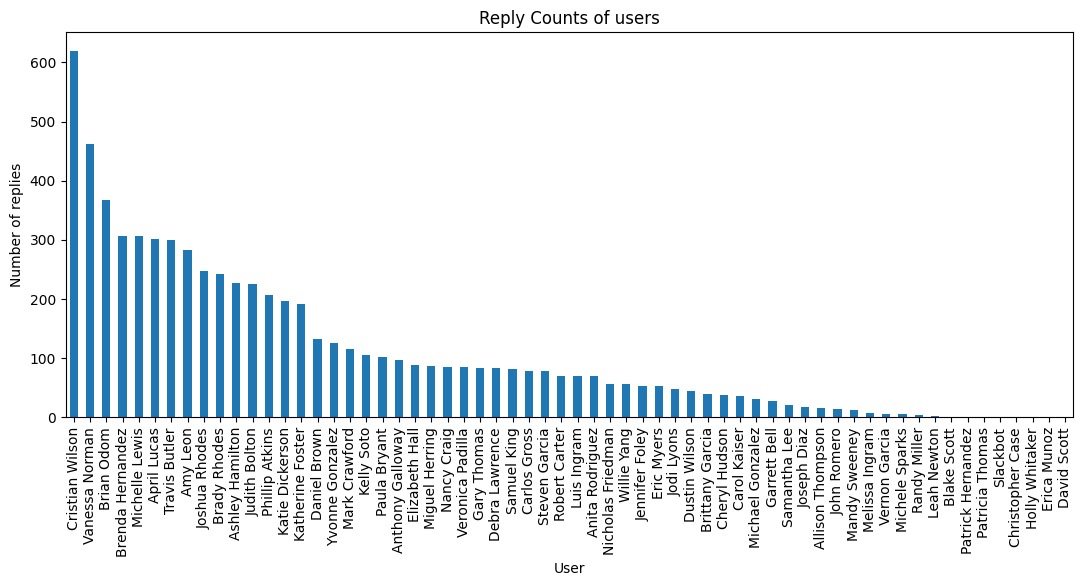

In [47]:
# which user has the highest number of reply counts?
def plot_highest_reply_count(data: DataFrame):
    gr_df = data.groupby('sender_name')['reply_count'].sum()
    gr_df = gr_df.sort_values(ascending=False)
    gr_df.plot(kind='bar', figsize=(13, 5))
    
    plt.title('Reply Counts of users')
    plt.xlabel('User')
    plt.ylabel('Number of replies')
    plt.show()

plot_highest_reply_count(df)

In [ ]:
# Visualize reply counts per user per channel

In [ ]:
# what is the time range of the day that most messages are sent?


In [11]:
# what kind of messages are replied faster than others?

In [15]:
# Relationship between # of messages and # of reactions

In [16]:
# Classify messages into different categories such as questions, answers, comments, etc.

In [17]:
# Which users got the most reactions?

In [33]:
# Model topics mentioned in the channel

In [ ]:
# What are the topics that got the most reactions?

### Harder questions to look into

In [ ]:
# Based on messages, reactions, references shared, and other relevant data such as classification of questions into techical question, comment, answer, aorder stu the python, statistics, and sql skill level of a user?